In [677]:
!pip install hyperopt


In [165]:
pip install -U xgboost


                                              0.0/99.8 MB ? eta -:--:--
                                              0.3/99.8 MB 6.5 MB/s eta 0:00:16
                                              0.7/99.8 MB 8.3 MB/s eta 0:00:12
                                              1.0/99.8 MB 7.3 MB/s eta 0:00:14
                                              1.5/99.8 MB 7.9 MB/s eta 0:00:13
                                              2.0/99.8 MB 8.5 MB/s eta 0:00:12
     -                                        2.5/99.8 MB 8.9 MB/s eta 0:00:11
     -                                        3.1/99.8 MB 9.4 MB/s eta 0:00:11
     -                                        3.7/99.8 MB 9.7 MB/s eta 0:00:10
     -                                        4.3/99.8 MB 10.2 MB/s eta 0:00:10
     --                                       5.1/99.8 MB 10.8 MB/s eta 0:00:09
     --                                       5.8/99.8 MB 11.3 MB/s eta 0:00:09
     --                                       6.6/99.8 M

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# TIER-1

In [25]:
train_split=pd.read_csv('./Train.csv')

test_split=pd.read_csv('./Test.csv')


X_train_ = train_split.drop(['site_no','Mean Discharge','RatingCurve_Expo'],axis=1)

X_val_ = test_split.drop(['site_no','Mean Discharge','RatingCurve_Expo'],axis=1)

y_train_ = train_split[['RatingCurve_Expo']]
y_val_ = test_split[['RatingCurve_Expo']]

print(X_val_)

           Qobs     W_mean    D_mean  (W/D)mean  Stage_mean       Qbank   
0      6.603478  22.440900  0.944880      23.75    0.466344   35.180935  \
1     12.069244  25.257252  0.678180      37.24    0.646176   44.457378   
2     23.899380  40.538400  0.655320      61.86    0.960120   55.143714   
3     42.145424  71.738033  1.478280      48.53    1.542288  136.413272   
4     10.533850  25.798272  1.456944      17.71    1.331976   17.505220   
..          ...        ...       ...        ...         ...         ...   
458  106.382399  52.236624  2.795016      18.69    2.243328  261.088522   
459    9.988978  36.447984  0.650443      56.04    0.752856  359.798002   
460   87.895860  41.553994  4.670146       8.90    4.437888  126.475802   
461   13.105242  22.806355  0.582168      39.17    3.054096  225.344564   
462    9.323873  17.761001  1.198474      14.82    1.005840   52.644671   

        W_bank    D_bank  (W/D)bank  Stage_bank  ...    D50_mm  Mean Elev   
0    22.959365  1.5880

# TIER-2

In [34]:
train_split=pd.read_csv('./Train_secondtier.csv')

test_split=pd.read_csv('./Test_secondtier.csv')

X_train_ = train_split.drop(['site_no','RatingCurve Exponent'], axis=1)

X_val_ = test_split.drop(['site_no','RatingCurve Exponent'],axis=1)

y_train_ = train_split[['RatingCurve Exponent']]

y_val_ = test_split[['RatingCurve Exponent']]

print(y_train_)

      RatingCurve Exponent
0                 0.615246
1                 0.329056
2                 0.450570
3                 0.433070
4                 0.365315
...                    ...
1580              0.212331
1581              0.422158
1582              0.414356
1583              0.494579
1584              0.531202

[1585 rows x 1 columns]


In [35]:
# Import necessary libraries
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score
from hyperopt import hp, fmin, tpe, Trials


space = {
    'max_depth': hp.quniform("max_depth", 2, 20, 1), 
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 1),  
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.7)),  
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),  
    'subsample': hp.uniform('subsample', 0.8, 1), 
    'gamma': hp.uniform('gamma', 0, 0.3),  
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.2, 1),  
    'reg_alpha': hp.uniform('reg_alpha', 0, 10), 
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),  
    'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1) , 
    'tree_method':hp.choice('tree_method',['auto','exact','approx']),
    'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
}

# Objective function
def objective(space):
    params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'n_estimators': int(space['n_estimators']),
        'min_child_weight': space['min_child_weight'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'gamma': space['gamma'],
        'scale_pos_weight': space['scale_pos_weight'],
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'max_delta_step': int(space['max_delta_step']),
        'tree_method':space['tree_method']
        
    }

    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train_.to_numpy(), y_train_.to_numpy().ravel())

    pred = xgb_model.predict(X_val_.to_numpy())
    accuracy = r2_score(y_val_, pred)

    return {'loss': -accuracy, 'status': STATUS_OK }

# Example usage of hyperopt's fmin function



In [36]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

100%|████| 1000/1000 [15:32<00:00,  1.07trial/s, best loss: -0.7156886307538537]


In [37]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'booster': 2, 'colsample_bytree': 0.8977513600949637, 'gamma': 0.004953804415573013, 'learning_rate': 0.041108759849070406, 'max_delta_step': 5.0, 'max_depth': 20.0, 'min_child_weight': 3.0, 'n_estimators': 4, 'reg_alpha': 0.9396301215486413, 'reg_lambda': 5.076348664888728, 'scale_pos_weight': 0.3388160845278136, 'subsample': 0.846425538471829, 'tree_method': 1}


In [29]:
##Tier 1

xgb_model = xgb.XGBRegressor(colsample_bytree=0.911,scale_pos_weight=0.728,subsample=0.935,reg_alpha=2.38, reg_lambda=4.79, learning_rate=0.074, max_depth=4,max_delta_step= 1.0 ,min_child_weight=4.0, n_estimators=400,gamma=0.054,random_state=42)

In [38]:
# TIer-2

xgb_model = xgb.XGBRegressor(colsample_bytree=0.897,scale_pos_weight=0.338,subsample=0.846,reg_alpha=0.939, reg_lambda=5.076, learning_rate=0.041, max_depth=20,max_delta_step= 5.0 ,min_child_weight=3.0, n_estimators=500,gamma=0.004,random_state=42)

In [39]:
##Training

xgb_model.fit(X_train_.to_numpy(), y_train_.to_numpy().ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.897, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.004, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.041, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=5.0,
             max_depth=20, max_leaves=None, min_child_weight=3.0, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [40]:
import pickle

with open(r'.\xgb_best_model', "wb") as fp:
    pickle.dump(xgb_model, fp)

In [41]:
import pickle

with open(r'.\xgb_best_model',"rb") as fp:
    xgb_model = pickle.load(fp)

R-squared: 0.6975708863349075


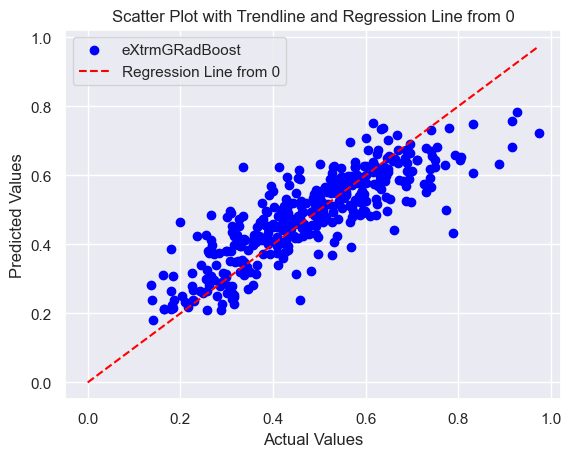

In [42]:
##Testing##

y_pred = xgb_model.predict(X_val_)

site_no=test_split['site_no']


result_df = pd.DataFrame({
    'Actual': np.ravel(y_val_),
    'Predicted': np.ravel(y_pred),
})

r2 = r2_score(y_val_, y_pred)



print(f'R-squared: {r2}')

plt.scatter(y_val_,y_pred, label='eXtrmGRadBoost', color='blue', marker='o')

y_val_ = np.ravel(y_val_)
y_pred = np.ravel(y_pred)
y_train_=np.ravel(y_train_)

# Regression line from 0 to the maximum y-axis value
max_y = max(max(y_pred),max(y_val_))
plt.plot([0, max_y], [0, max_y], color='red', linestyle='--', label='Regression Line from 0')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot with Trendline and Regression Line from 0')
plt.legend()
plt.show()
